In [1]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from resnet_yolo import resnet50
from yolo_loss import YoloLoss
from dataset import VocDetectorDataset
from eval_voc import evaluate
from predict import predict_image
from predict import predict_video
from config import VOC_CLASSES, COLORS
import time
# from kaggle_submission import output_submission_csv
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effictively.

In [4]:
load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


In [5]:
learning_rate = 0.001
num_epochs = 60
batch_size = 15

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

In [6]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection dataset since the bounding box annotations must be kept consistent through the transformations.

Since the output of the dector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [7]:
file_root_train = 'VOCdevkit/VOC2007/JPEGImages/'
annotation_file_train = 'voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [8]:
file_root_test = 'VOCdevkit_test/VOC2007/JPEGImages/'
annotation_file_test = 'voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


## Train detector

In [15]:
# best_test_loss = np.inf

# for epoch in range(num_epochs):
#     net.train()
    
#     # Update learning rate late in training
#     if epoch == 30 or epoch == 40:
#         learning_rate /= 10.0

#     for param_group in optimizer.param_groups:
#         param_group['lr'] = learning_rate
    
#     print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
#     print('Learning Rate for this epoch: {}'.format(learning_rate))
    
#     total_loss = 0.
    
#     for i, (images, target) in enumerate(train_loader):
#         images, target = images.to(device), target.to(device)
        
#         pred = net(images)
#         loss = criterion(pred,target)
#         total_loss += loss.item()
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         if (i+1) % 5 == 0:
#             print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f'
#                   % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))
    
#     # evaluate the network on the test data
#     with torch.no_grad():
#         test_loss = 0.0
#         net.eval()
#         for i, (images, target) in enumerate(test_loader):
#             images, target = images.to(device), target.to(device)

#             pred = net(images)
#             loss = criterion(pred,target)
#             test_loss += loss.item()
#         test_loss /= len(test_loader)
    
#     if best_test_loss > test_loss:
#         best_test_loss = test_loss
#         print('Updating best test loss: %.5f' % best_test_loss)
#         torch.save(net.state_dict(),'best_detector.pth')

#     torch.save(net.state_dict(),'detector.pth')
    


In [16]:
avg_train_loss=[]
avg_test_loss=[]

In [17]:
best_test_loss = np.inf
for epoch in range(num_epochs):
    tic = time.time()
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = 0.
    
    for i, (images, target) in enumerate(train_loader):
        images, target = images.to(device), target.to(device)
        
        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         if (i+1) % 50 == 0:
#             print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f'
#                   % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))
    
    # evaluate the network on the test data
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for j, (images, target) in enumerate(test_loader):
            images, target = images.to(device), target.to(device)

            pred = net(images)
            loss = criterion(pred,target)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    toc = time.time()-tic
    avg_train_loss.append(total_loss / (i+1))
    avg_test_loss.append(test_loss)
    print('Epoch [%d/%d],Training_loss: %.4f, Val_loss: %.4f,time: %.f min %.f sec'
                  % (epoch+1, num_epochs, total_loss / (i+1),test_loss,toc//60,toc%60))
    
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'best_detector.pth')

    torch.save(net.state_dict(),'detector.pth')
    




Starting epoch 1 / 60
Learning Rate for this epoch: 0.001


/home/hulk-css/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch [1/60],Training_loss: 8.9986, Val_loss: 5.1579,time: 2 min 5 sec
Updating best test loss: 5.15788


Starting epoch 2 / 60
Learning Rate for this epoch: 0.001
Epoch [2/60],Training_loss: 4.7724, Val_loss: 4.4982,time: 2 min 3 sec
Updating best test loss: 4.49821


Starting epoch 3 / 60
Learning Rate for this epoch: 0.001
Epoch [3/60],Training_loss: 4.2467, Val_loss: 4.1576,time: 2 min 3 sec
Updating best test loss: 4.15763


Starting epoch 4 / 60
Learning Rate for this epoch: 0.001
Epoch [4/60],Training_loss: 3.9586, Val_loss: 4.0255,time: 2 min 5 sec
Updating best test loss: 4.02545


Starting epoch 5 / 60
Learning Rate for this epoch: 0.001
Epoch [5/60],Training_loss: 3.7063, Val_loss: 3.7176,time: 2 min 3 sec
Updating best test loss: 3.71758


Starting epoch 6 / 60
Learning Rate for this epoch: 0.001
Epoch [6/60],Training_loss: 3.5585, Val_loss: 3.6016,time: 2 min 3 sec
Updating best test loss: 3.60161


Starting epoch 7 / 60
Learning Rate for this epoch: 0.001
Epoch [7/60],Tra

Epoch [55/60],Training_loss: 1.8005, Val_loss: 2.6559,time: 2 min 14 sec


Starting epoch 56 / 60
Learning Rate for this epoch: 1e-05
Epoch [56/60],Training_loss: 1.7868, Val_loss: 2.6437,time: 2 min 16 sec


Starting epoch 57 / 60
Learning Rate for this epoch: 1e-05
Epoch [57/60],Training_loss: 1.8065, Val_loss: 2.6465,time: 2 min 15 sec


Starting epoch 58 / 60
Learning Rate for this epoch: 1e-05
Epoch [58/60],Training_loss: 1.7869, Val_loss: 2.6136,time: 2 min 17 sec
Updating best test loss: 2.61356


Starting epoch 59 / 60
Learning Rate for this epoch: 1e-05
Epoch [59/60],Training_loss: 1.8694, Val_loss: 2.6694,time: 2 min 13 sec


Starting epoch 60 / 60
Learning Rate for this epoch: 1e-05
Epoch [60/60],Training_loss: 1.7704, Val_loss: 2.6399,time: 2 min 15 sec


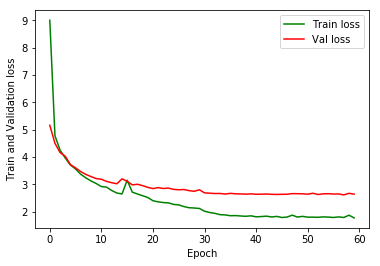

In [18]:
# plt.plot(avg_train_loss,'g', avg_test_loss, 'r')
# plt.show()

import matplotlib.pyplot as plt
plt.plot(avg_train_loss,'g',label='Train loss')
plt.plot(avg_test_loss, 'r',label='Val loss')
plt.xlabel("Epoch")
plt.ylabel("Train and Validation loss")
plt.legend()
plt.show()

# View example predictions

predicting...


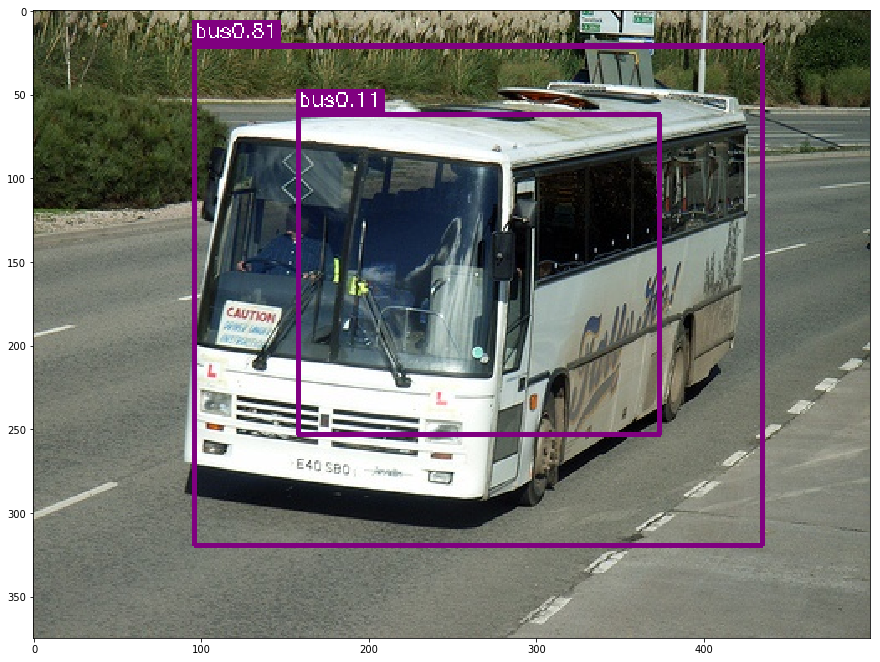

In [27]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
net.load_state_dict(torch.load("detector.pth"))
print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
cv2.imwrite('result.png',image)
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [ ]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test)

In [ ]:
output_submission_csv('my_solution.csv', test_aps)

In [10]:
import cv2 
import numpy as np
import argparse
import sys
import scipy.misc

######################Weight for Camvid ####################

######################################################################
cap = cv2.VideoCapture('0005VD.MXF') 
count = 0
ret=1
fourcc1 = cv2.VideoWriter_fourcc(*'XVID')


out1 = cv2.VideoWriter('video.avi',fourcc1, 20.0, (480,360))

net.load_state_dict(torch.load("detector.pth"))
while ret:
    
    cap.set(cv2.CAP_PROP_POS_MSEC,count*20)      # Go to the 1 sec. position
    ret,frame = cap.read()
 
    if ret:
        frame = cv2.resize(frame, (480, 360))
        
        frame1 = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        result = predict_video(net, frame1)
        for left_up, right_bottom, class_name, prob in result:
            color = COLORS[VOC_CLASSES.index(class_name)]
            cv2.rectangle(frame, left_up, right_bottom, color, 2)
            label = class_name + str(round(prob, 2))
            text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
            p1 = (left_up[0], left_up[1] - text_size[1])
            cv2.rectangle(frame, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
            cv2.putText(frame, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

        cv2.imshow('Video',frame)
        out1.write(frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    count += 1
cap.release()
out1.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 